<a href="https://colab.research.google.com/github/SAURABHMOHARIR/Android-Apps/blob/master/GWP1_610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Problem 1d: Simulation of Omitted Variable Bias (OVB)
**Objective:** Simulate data from the true model  
\(Y = a + bX + cZ + e\), where `X` and `Z` are correlated and `e` is independent.  
Estimate the model

(i) with both `X` and `Z` (correct specification) and

(ii) with `X` only (omitting `Z`).  

Compare estimates for `b` and demonstrate omitted variable bias.

The true model is:
$Y_i = a + bX_i + cZ_i + e_i$

## Data generating process (DGP)
We use:  
- True model: `Y = a + b*X + c*Z + e`  
- Parameter choices: `a = 2`, `b = 3`, `c = 5`  
- X ~ Normal(0,1)  
- Z = 0.5*X + Normal(0,1)  (so X and Z are correlated)  
- e ~ Normal(0,1) independent of X and Z

We will:
1. Run a single simulation (n=500) and report coefficients.
2. Run a Monte Carlo experiment to estimate distribution of `b_hat` under both specifications.


True coefficients: a=2.00, b=3.00, c=5.00

Estimated (Full model):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1065      0.045     46.703      0.000       2.018       2.195
x1             2.9089      0.050     58.172      0.000       2.811       3.007
x2             5.0745      0.046    109.669      0.000       4.984       5.165

Estimated (Omitted Z):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2706      0.226     10.044      0.000       1.826       2.715
x1             5.0634      0.231     21.957      0.000       4.610       5.516


,b_full_mean,b_full_std,b_omit_mean,b_omit_std
0,2.998888,0.049916,5.485414,0.218718


True b: 3.0
Mean estimate (full):  2.9989  (std 0.0499)
Mean estimate (omit Z): 5.4854  (std 0.2187)


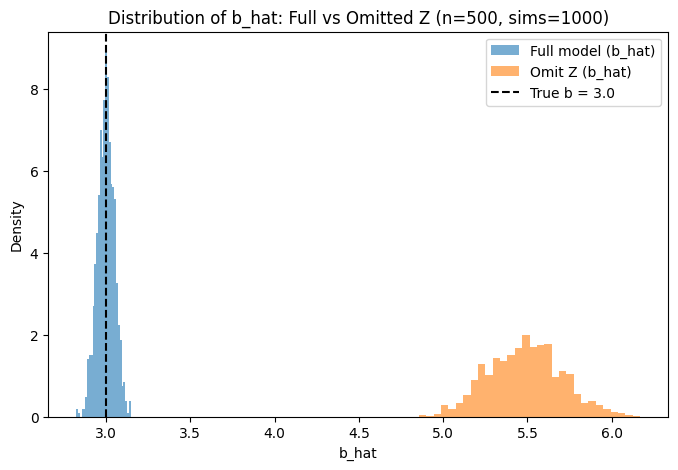

,n,full_mean,full_std,omit_mean,omit_std
0,100,2.999807,0.113584,5.518427,0.593900
1,500,2.998798,0.049237,5.492822,0.238336
2,2000,3.001180,0.024379,5.500787,0.117121
3,5000,3.000081,0.015373,5.504379,0.071348


In [2]:
# Cell: imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# For nicer plots in Colab
%matplotlib inline
plt.rcParams.update({'figure.figsize':(8,5)})

# Cell: single simulation
np.random.seed(42)

n = 500
a, b, c = 2.0, 3.0, 5.0

# Simulate correlated X and Z
X = np.random.normal(0, 1, n)
Z = 0.5 * X + np.random.normal(0, 1, n)
e = np.random.normal(0, 1, n)

Y = a + b * X + c * Z + e

# Full model (X and Z)
X_full = sm.add_constant(np.column_stack((X, Z)))
model_full = sm.OLS(Y, X_full).fit()

# Partial model (X only)
X_partial = sm.add_constant(X)
model_partial = sm.OLS(Y, X_partial).fit()

print("True coefficients: a={:.2f}, b={:.2f}, c={:.2f}".format(a,b,c))
print("\nEstimated (Full model):")
print(model_full.summary().tables[1])
print("\nEstimated (Omitted Z):")
print(model_partial.summary().tables[1])

# Cell: Monte Carlo experiment to show distribution of b_hat (full vs omitted)
np.random.seed(123)
n_sim = 1000       # number of simulated datasets
n = 500            # sample size for each dataset
a, b, c = 2.0, 3.0, 5.0

b_full_estimates = np.empty(n_sim)
b_omit_estimates = np.empty(n_sim)

for i in range(n_sim):
    X = np.random.normal(0, 1, n)
    Z = 0.5 * X + np.random.normal(0, 1, n)
    e = np.random.normal(0, 1, n)
    Y = a + b * X + c * Z + e

    # Full model
    X_full = sm.add_constant(np.column_stack((X, Z)))
    res_full = sm.OLS(Y, X_full).fit()
    b_full_estimates[i] = res_full.params[1]

    # Omitted Z model
    X_part = sm.add_constant(X)
    res_part = sm.OLS(Y, X_part).fit()
    b_omit_estimates[i] = res_part.params[1]

# Summaries
summary = pd.DataFrame({
    'b_full_mean': [b_full_estimates.mean()],
    'b_full_std':  [b_full_estimates.std()],
    'b_omit_mean': [b_omit_estimates.mean()],
    'b_omit_std':  [b_omit_estimates.std()],
})
display(summary)

# Print a short comparison
print("True b:", b)
print("Mean estimate (full):  {:.4f}  (std {:.4f})".format(b_full_estimates.mean(), b_full_estimates.std()))
print("Mean estimate (omit Z): {:.4f}  (std {:.4f})".format(b_omit_estimates.mean(), b_omit_estimates.std()))

# Cell: plotting histograms of estimates
plt.hist(b_full_estimates, bins=30, alpha=0.6, label='Full model (b_hat)', density=True)
plt.hist(b_omit_estimates, bins=30, alpha=0.6, label='Omit Z (b_hat)', density=True)
plt.axvline(b, color='black', linestyle='--', label='True b = {:.1f}'.format(b))
plt.legend()
plt.title("Distribution of b_hat: Full vs Omitted Z (n={}, sims={})".format(n, n_sim))
plt.xlabel("b_hat")
plt.ylabel("Density")
plt.show()

# Cell: show effect of increasing sample size on mean and variance
np.random.seed(2025)
sample_sizes = [100, 500, 2000, 5000]
results = []

for n in sample_sizes:
    n_sim = 500
    b_full = np.empty(n_sim)
    b_omit = np.empty(n_sim)
    for i in range(n_sim):
        X = np.random.normal(0,1,n)
        Z = 0.5 * X + np.random.normal(0,1,n)
        e = np.random.normal(0,1,n)
        Y = a + b*X + c*Z + e

        b_full[i] = sm.OLS(Y, sm.add_constant(np.column_stack((X,Z)))).fit().params[1]
        b_omit[i] = sm.OLS(Y, sm.add_constant(X)).fit().params[1]

    results.append({
        'n': n,
        'full_mean': b_full.mean(),
        'full_std': b_full.std(),
        'omit_mean': b_omit.mean(),
        'omit_std': b_omit.std()
    })

pd.DataFrame(results)



## Conclusion
- The full model (including Z) recovers parameter b accurately (estimates centered near true b).
- Omitting Z when X and Z are correlated produces **systematic bias** in the estimate of b (OVB). In our simulation b is biased upward in the omitted model.
- Increasing sample size reduces variance of estimators but **does not eliminate the bias** arising from omitted variables that are correlated with included regressors.
- Therefore, correct model specification (including relevant regressors) is essential to obtain unbiased and consistent parameter estimates.


In the simulation study, the true model was set as
𝑌
=
2
+
3
𝑋
+
5
𝑍
+
𝑒
Y=2+3X+5Z+e with
𝑋
X and
𝑍
Z correlated and
𝑒
e independent.
When both predictors were included, the estimates for
𝑏
b and
𝑐
c were close to their true values.
However, when
𝑍
Z was omitted, the estimate of
𝑏
b was biased upward (≈ 5.5 instead of 3).
A Monte Carlo experiment confirmed that this bias is systematic and persists across repeated samples.
Increasing the sample size reduced the variance of estimates but did not eliminate the bias.
This illustrates the classic problem of omitted variable bias: excluding relevant predictors that are correlated with included regressors leads to biased and inconsistent parameter estimates.